# Implementing Self-supervised Learning on CIFAR-10

Let's import the necessary libraries

In [2]:
try:
    from astra.torch.models import ResNetClassifier
    import umap.umap_ as umap
except:
    %pip install git+https://github.com/sustainability-lab/ASTRA
    %pip install umap-learn

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import umap.umap_ as umap

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# ASTRA
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn
from astra.torch.models import ResNetClassifier

from itertools import permutations

/usr/local/lib/python3.10/dist-packages/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /root/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Loading Data

In [5]:
dataset = load_cifar_10()
dataset

100%|██████████| 170498071/170498071 [00:05<00:00, 29005821.20it/s]


Extracting /root/.cache/torch/data/cifar-10-python.tar.gz to /root/.cache/torch/data
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
range of image values: min=0.0, max=1.0
            

### Plotting some images

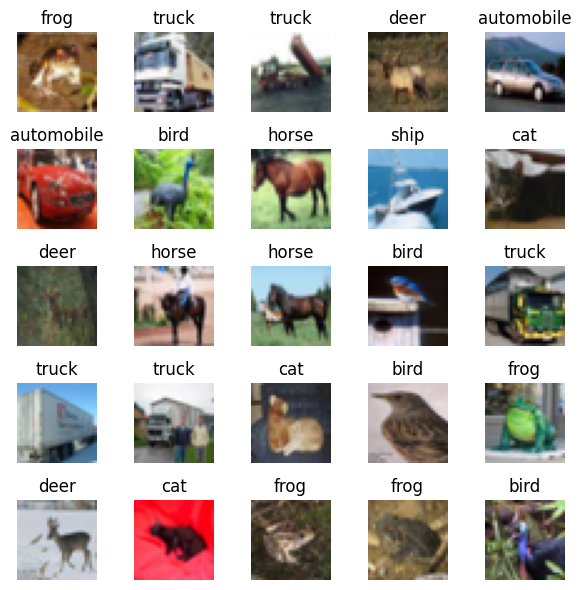

In [6]:
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(torch.einsum("chw->hwc", dataset.data[i].cpu()))
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

### Splitting Data

In [7]:
n_train = 1000
n_test = 20000

X = dataset.data
y = dataset.targets

print(X.shape)
print(X.shape, X.dtype)
print(X.min(), X.max())
print(y.shape, y.dtype)

torch.Size([60000, 3, 32, 32])
torch.Size([60000, 3, 32, 32]) torch.float32
tensor(0.) tensor(1.)
torch.Size([60000]) torch.int64


In [8]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(len(train_idx), len(pool_idx), len(test_idx))

1000 39000 20000


In [9]:
resnet = ResNetClassifier(models.resnet18, models.ResNet18_Weights.DEFAULT, n_classes=10).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 269MB/s]


In [10]:
resnet

ResNetClassifier(
  (featurizer): ResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

In [11]:
def get_accuracy(net, X, y):
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
        return y_pred, acc

def predict(net, classes, plot_confusion_matrix=False):
    for i, (name, idx) in enumerate(zip(("train", "pool", "test"), [train_idx, pool_idx, test_idx])):
        X_dataset = X[idx].to(device)
        y_dataset = y[idx].to(device)
        y_pred, acc = get_accuracy(net, X_dataset, y_dataset)
        print(f'{name} set accuracy: {acc*100:.2f}%')
        if plot_confusion_matrix:
            cm = confusion_matrix(y_dataset.cpu(), y_pred.cpu())
            cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d'
                                                                                , cmap='Blues')
            # Rotate the labels on x-axis to make them readable
            _ = plt.xticks(rotation=90)
            plt.show()



### Predicting results without training

train set accuracy: 7.70%


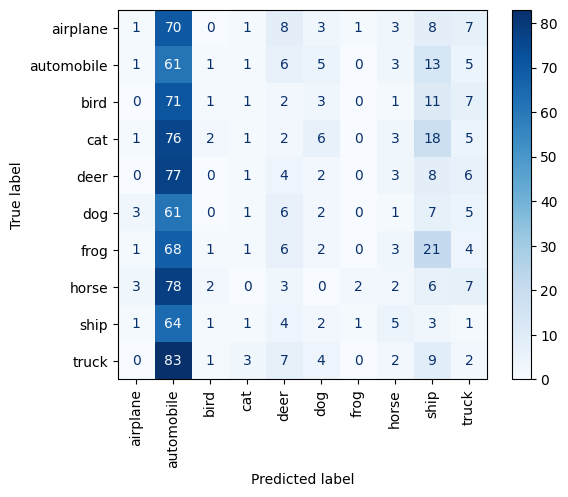

pool set accuracy: 8.37%


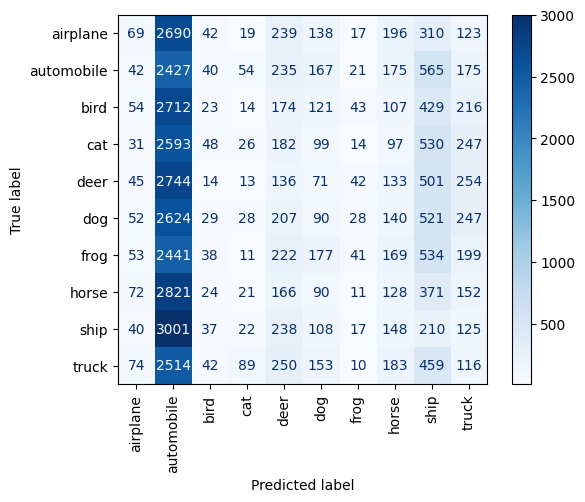

test set accuracy: 8.57%


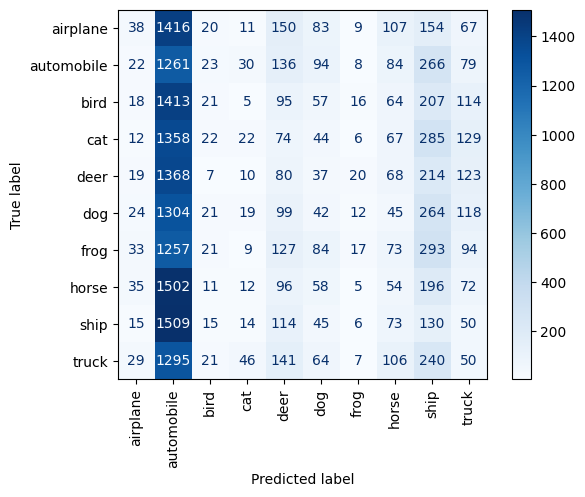

In [12]:
predict(resnet,dataset.classes,plot_confusion_matrix=True)

### Visualizing embeddings

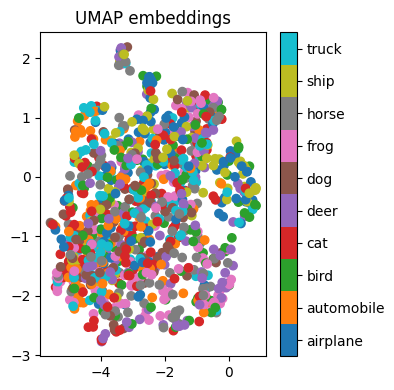

In [13]:
def viz_embeddings(net, X, y, device):
    reducer = umap.UMAP()
    with torch.no_grad():
        emb = net.featurizer(X.to(device))
    emb = emb.cpu().numpy()
    emb = reducer.fit_transform(emb)
    plt.figure(figsize=(4, 4))
    plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu().numpy(), cmap='tab10')
    # Add a colorbar legend to mark color to class mapping
    cb = plt.colorbar(boundaries=np.arange(11)-0.5)
    cb.set_ticks(np.arange(10))
    cb.set_ticklabels(dataset.classes)
    plt.title("UMAP embeddings")
    plt.tight_layout()
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

### Training model on train set

In [15]:
resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
iter_losses, epoch_losses = train_fn(resnet,nn.CrossEntropyLoss(), X[train_idx], y[train_idx], lr=3e-4,
                                     batch_size=128, epochs=30, verbose=False)

Text(0, 0.5, 'Training loss')

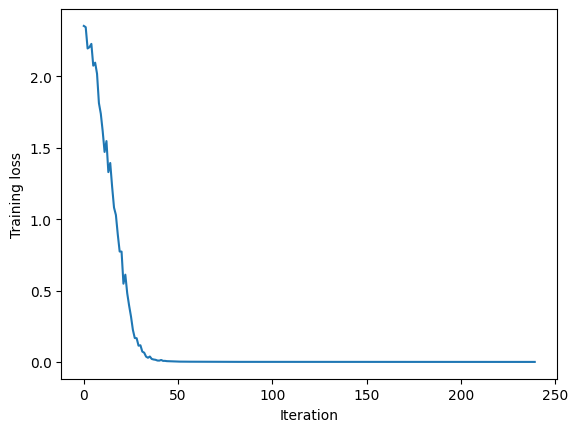

In [16]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

train set accuracy: 100.00%


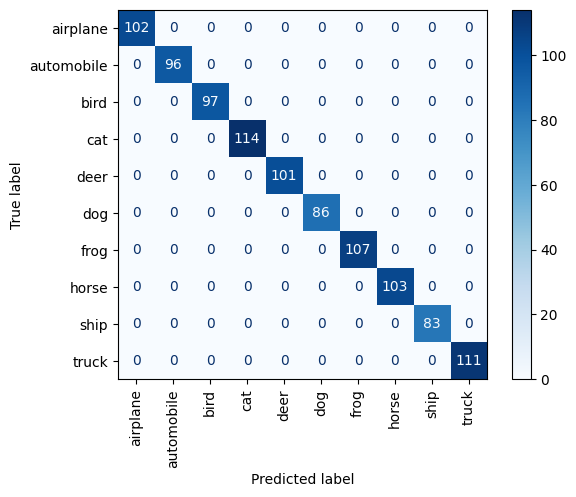

pool set accuracy: 36.67%


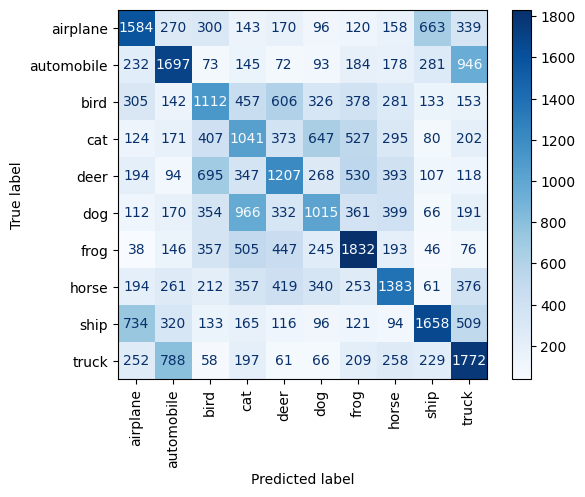

test set accuracy: 36.68%


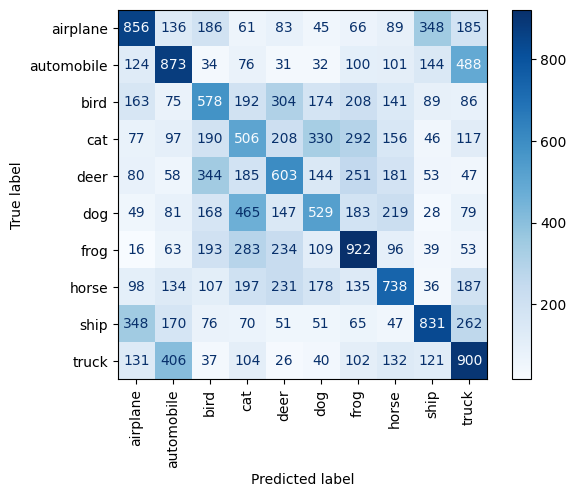

In [17]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


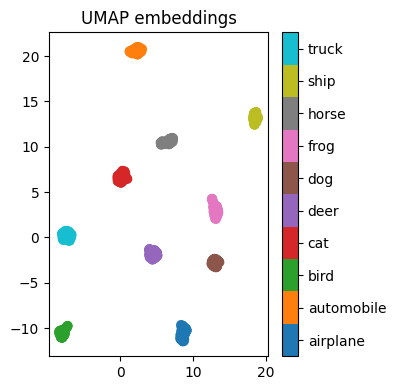

In [18]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

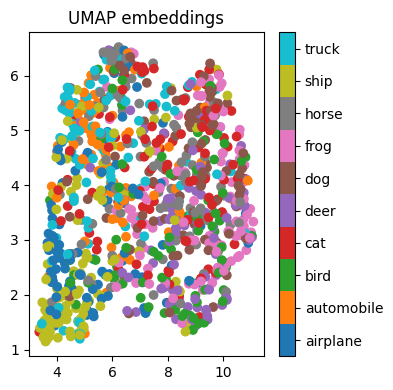

In [19]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

In [21]:
### Train on train + pool
train_plus_pool_idx = torch.cat([train_idx, pool_idx])

resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)

iter_losses, epoch_losses = train_fn(resnet,nn.CrossEntropyLoss(), X[train_plus_pool_idx], y[train_plus_pool_idx],
                                     lr=3e-4,
                                        batch_size=1024, epochs=30)

Loss: 0.02632799: 100%|██████████| 30/30 [06:43<00:00, 13.44s/it]


Text(0, 0.5, 'Training loss')

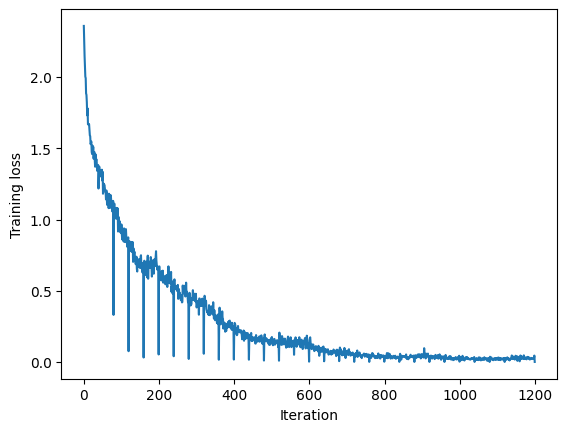

In [22]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

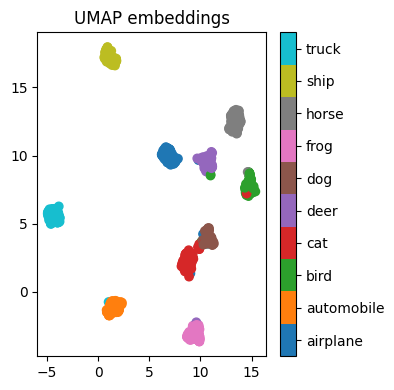

In [23]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

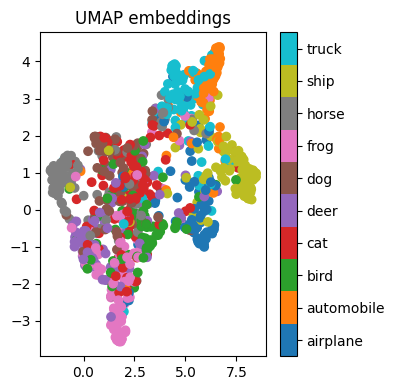

In [24]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 99.40%


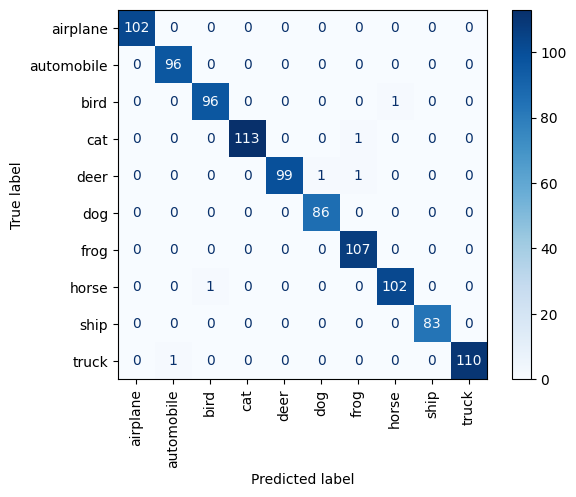

pool set accuracy: 99.00%


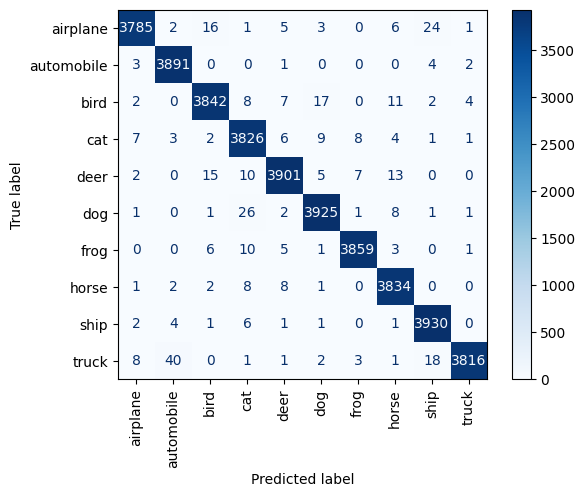

test set accuracy: 62.60%


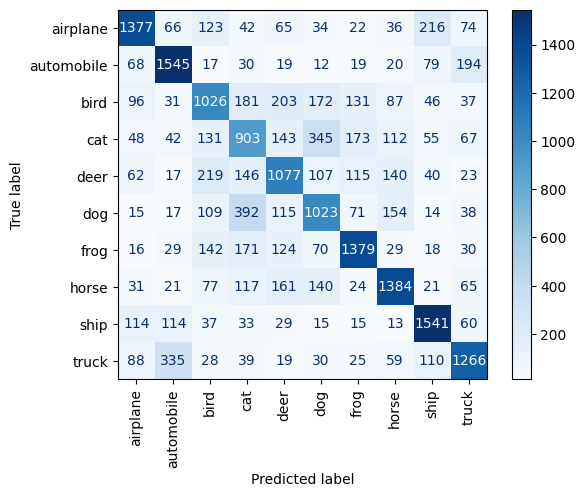

In [25]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

## SSL

Task: Dividing images into patches and permuting them. Predict the permutation number as a classification task

In [26]:
X_train_plus_pool = torch.cat([X[train_idx], X[pool_idx]])
y_train_plus_pool = torch.cat([y[train_idx], y[pool_idx]])


X_train_plus_pool.shape, y_train_plus_pool.shape

(torch.Size([40000, 3, 32, 32]), torch.Size([40000]))

In [27]:
# Divinding image into 4 patches of 8x8
def divide_into_patches(images):                  # images = (#,3,32,32), # = number of images
  patches = torch.split(images,16,dim=3)
  patches = [torch.unsqueeze(patch,1) for patch in patches]
  patches = torch.cat(patches,dim=1)
  patches = torch.split(patches,16,dim=3)
  patches = torch.cat(patches,dim=1)
  return patches


images_with_patches = divide_into_patches(X_train_plus_pool)
images_with_patches.shape

torch.Size([40000, 4, 3, 16, 16])

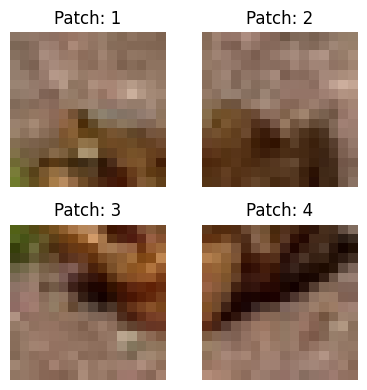

In [28]:
# Viusalizing patches
sample_image = images_with_patches[0]
plt.figure(figsize=(4, 4))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(torch.einsum("chw->hwc", sample_image[i]))
    plt.axis('off')
    plt.title(f"Patch: {i+1}")
plt.tight_layout()

torch.Size([3, 32, 32])


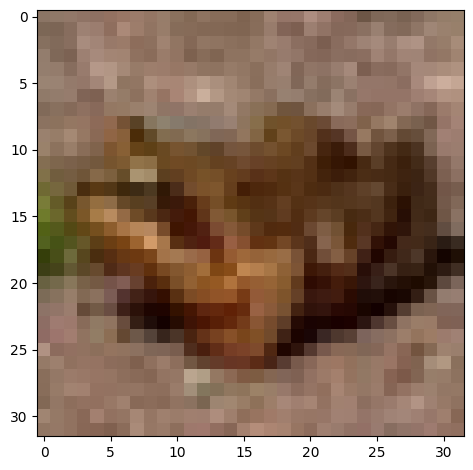

In [29]:
# Original image
print(X_train_plus_pool[0].shape)
plt.imshow(torch.einsum("chw->hwc", X_train_plus_pool[0]))
plt.tight_layout()

In [ ]:
X_ssl = []
y_ssl = []


angles_map = {0:0, 90:1, 180:2, 270:3}
for angle_rot in angles_map.keys():
    print(f"Angle: {angle_rot}")
    X_rot = transforms.functional.rotate(X_train_plus_pool, angle_rot)
    X_ssl.append(X_rot)
    y_ssl.append(torch.tensor([angles_map[angle_rot]]*len(X_rot)))

X_ssl = torch.cat(X_ssl)
y_ssl = torch.cat(y_ssl)

In [ ]:
X_ssl.shape,y_ssl.shape

In [ ]:
# Plot same image rotated at different angles
def plot_ssl(img_id):
    plt.figure(figsize=(3, 3))
    offset = len(X_train_plus_pool)
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(torch.einsum("chw->hwc", X_ssl[offset*i + img_id]))
        plt.axis('off')
        plt.title(f"Class: {angles_map[i*90]}\n Angle: {i*90}")
    plt.tight_layout()
plot_ssl(2)